---
## Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file='traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import csv
import cv2
import numpy as np

In [8]:
# Debug flag
DEBUG = False

In [9]:
# Get class name from file
classNames = []
class_name_file = "signnames.csv"
with open (class_name_file) as fp:
    rows = csv.reader(fp, delimiter=',')
    print(type(rows))
    for i, row in enumerate(rows):
        if i == 0:
            continue
        classNames.append(row[1])

if DEBUG:
    for i, name in enumerate(classNames):
        print("{}: {}".format(i, name))

<class '_csv.reader'>


---
## Data Visualization

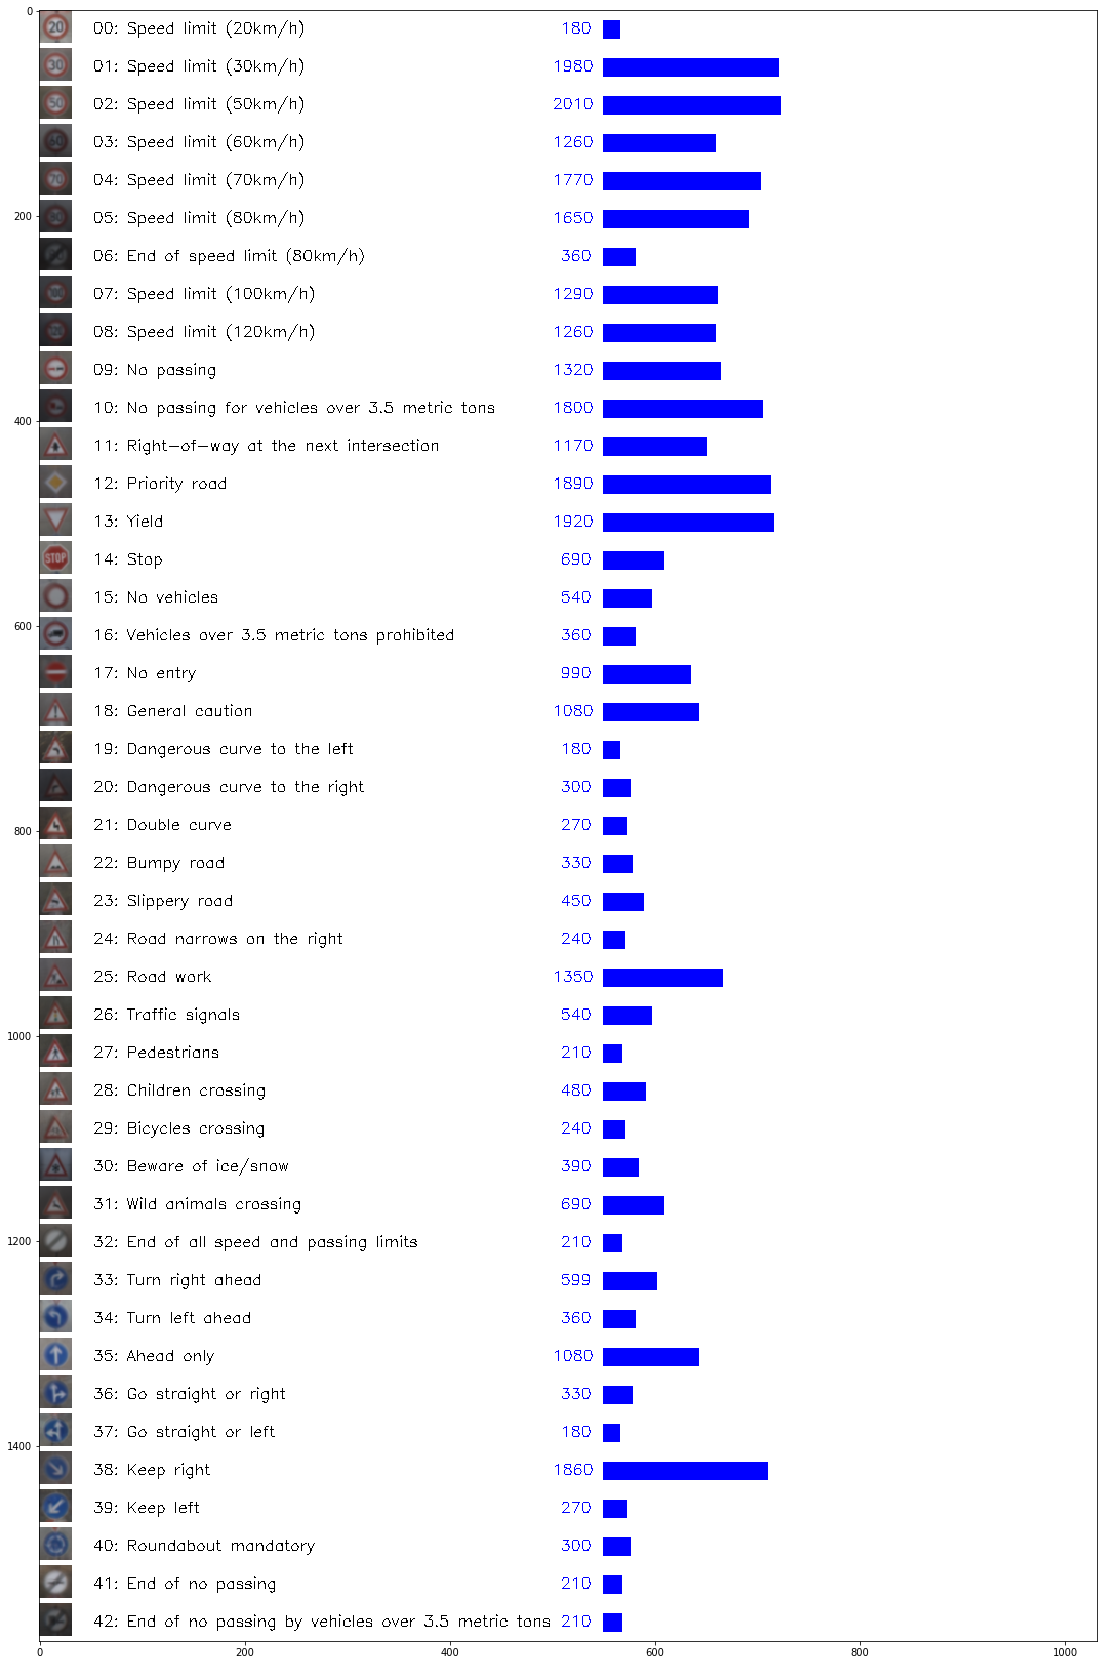

In [10]:
def display_traffic_sign_classes():
    
    # shape information for each traffic sign class image
    width = round(image_shape[0] * 1)
    height = round(image_shape[1] * 1)
    channel = image_shape[2]
    
    # shape for containing all traffic sign class images
    padding = 5
    signs_shape = ((height+padding)*n_classes, width + 1000, channel)
    if DEBUG:
        print("signs_shape: {}".format(signs_shape))
    
    # array(image) for containing all traffic sign class images
    signs_image = 255.*np.ones(shape=signs_shape, dtype=np.float32)
    
    # loop each traffic sign image and calc average image to place at corresponding position 
    # in signs_image
    for idx in range(n_classes):
        # Get all images belong to class
        indexes = list(np.where(y_train == idx)[0])
        # total count of class image
        count = len(indexes)
        # take average of class images
        mean_image = np.mean(X_train[indexes], axis=0)
        # resize averaged image
        mean_image = cv2.resize(mean_image, (width, height))
        
        # Draw(place) at corresponding position in signs_image
        yPos = height+padding
        signs_image[idx*yPos: idx*yPos+height, 0: width, :] = mean_image

        percentage = float(count)/float(len(y_train))

        # putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
        # Put text of traffic sign name
        cv2.putText(img=signs_image, 
                    text='%02d: %s'%(idx, classNames[idx]), 
                    org=(width+20, int((idx+0.6)*yPos)), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=0.5, 
                    color=(0,0,0), 
                    thickness=1
               )
        # Put text of number of traffic sign
        count_x_pos = 500
        cv2.putText(img=signs_image, 
                    text='%4d'%(count), 
                    org=(count_x_pos, int((idx+0.6)*yPos)), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=0.5, 
                    color=(0,0,255), 
                    thickness=1
               )
        # Put the histogram of ratio of traffic sign
        hist_x_pos = 550
        full_length = 3000
        # cv.Rectangle(img, pt1, pt2, color, thickness=1, lineType=8, shift=0) → None
        cv2.rectangle(img=signs_image, 
                      pt1=(hist_x_pos, int(idx*yPos) + 10), 
                      pt2=(hist_x_pos+round(percentage*full_length), int((idx+1)*yPos)-10), 
                      color=(0, 0, 255), 
                      thickness=-1
                     )
    
    cv2.imwrite('signs_image.jpg', signs_image)
    plt.rcParams["figure.figsize"] = (30,30)
    plt.imshow(signs_image.astype(np.uint8))

    
display_traffic_sign_classes()

---
## Data Augmentation

In [11]:
def image_flip(image, horizontal=True):
    if horizontal == True:
        return cv2.flip(image, 1)
    else:
        return cv2.flip(image, 2)

In [12]:
def image_rotate(image, angle, center=None, scale=1.0):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [13]:
def image_translate(image, x, y):
    (h, w) = image.shape[:2]
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (w, h))
    return shifted

In [14]:
# apply augmentation on "Children Crossing" class
target_class = 28
indexes = list(np.where(y_train == target_class)[0])
aug_images = []
aug_labels = []
for index in indexes:
    image = X_train[index]
#     rotated = image_rotate(image, 90)
    result = image_flip(image)
    aug_images.append(result)
    aug_labels.append(target_class)

# Before
print("X_train.count:{}".format(X_train.shape[0]))
print("y_train:{}".format(y_train.shape))

# Augmentation 
aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)
print("aug_images:{}".format(aug_images.shape))
print("aug_labels:{}".format(aug_labels.shape))

# After
X_train = np.vstack((X_train, aug_images))
print("X_train.count:{}".format(X_train.shape[0]))
y_train = np.hstack((y_train, aug_labels))
print("y_train:{}".format(y_train.shape))

#
aug_indexes = list(np.where(y_train == target_class)[0])
name = classNames[target_class]
print("{}.count: {}".format(name, len(aug_indexes)))

X_train.count:34799
y_train:(34799,)
aug_images:(480, 32, 32, 3)
aug_labels:(480,)
X_train.count:35279
y_train:(35279,)
Children crossing.count: 960


---
## Data Preprocessing

In [15]:
def normalize(img):
    #return color.rgb2gray(img/255.0-.5)
    y = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0]
#     print("y.shape:{}".format(y.shape))
    y = np.reshape(y, (y.shape[0], y.shape[1], 1))
    return y/255.0 - 0.5
#     yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#     return yuv

def HistEqualized(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray)
    return equ

In [16]:
X_train = [normalize(image) for image in X_train]
X_valid = [normalize(image) for image in X_valid]    
X_test = [normalize(image) for image in X_test]

---
## Build The Neural Network

In [17]:
import tensorflow as tf

In [18]:
def myConv2d(input_data, kernel, strides, padding, name):
    
    num_of_features = kernel.get_shape().as_list()[-1]
    
    bias = tf.Variable(tf.zeros(num_of_features))
    conv = tf.nn.conv2d(input=input_data, filter=kernel, strides=strides, padding=padding, name=name)
    conv = tf.nn.bias_add(value=conv, bias=bias)
#     conv = tf.nn.dropout(conv, keep_prob=keep_prob)
    conv = tf.nn.relu(conv)
    return conv

In [19]:
def myMaxPool(value, ksize, stride, padding, name):
    pool_size = [1,ksize,ksize,1]
    pool_strides = [1,stride,stride,1]
    maxPooling = tf.nn.max_pool(value=value, ksize=pool_size, strides=pool_strides, padding=padding, name=name)
    return maxPooling

In [20]:
def flatten(x_tensor):
    x_shape = x_tensor.get_shape().as_list()
    batch_size = x_shape[0]
    if batch_size is None:
        batch_size = -1
        
    image_height = x_shape[1]
    image_width = x_shape[2]
    image_depth = x_shape[3]
    flatten_size = image_height*image_width*image_depth
    # flatten_Size = np.prod(x_shape)
    flatten_layer = tf.reshape(x_tensor, [batch_size, flatten_size])
    return flatten_layer

In [21]:
def fully_conn(tensor, weight, keep_prob, name):
    
    num_of_weight = weight.get_shape().as_list()[-1]
    
    bias = tf.Variable(tf.zeros(num_of_weight))
    fc = tf.add(tf.matmul(tensor, weight), bias)
    fc = tf.nn.dropout(x=fc, keep_prob=keep_prob, )
    fc = tf.nn.relu(fc, name=name)
    return fc

In [22]:
def LeNet(x_tensor, keep_prob):
    
    # x_tensor : a tensor with shape (Batch_size, image_shape)
    
    # tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)
    # tf.nn.bias_add(value, bias, data_format=None, name=None)
    # tf.nn.max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)
    # tf.nn.dropout(x, keep_prob, noise_shape=None, seed=None, name=None)
    # tf.one_hot(indices, depth, on_value=None, off_value=None, axis=None, dtype=None, name=None)
    
    mu = 0
    sigma = 0.075
    
    x_depth = x_tensor.get_shape().as_list()[-1]
    
    # Conv Layer 1
    k1_depth = 64
    filter_strides = [1,1,1,1]
    wc1 = tf.Variable(tf.truncated_normal(shape=(5,5,x_depth, k1_depth), mean=mu, stddev=sigma))
    conv1 = myConv2d(input_data=x_tensor, kernel=wc1, strides=filter_strides, padding='VALID', name='Conv1')
    maxPool_1 = myMaxPool(value=conv1, ksize=2, stride=2, padding='VALID', name='MaxPool1')

    # Conv Layer 2
    k2_depth = 64
    filter_strides = [1,1,1,1]
    wc2 = tf.Variable(tf.truncated_normal(shape=(5,5,k1_depth, k2_depth), mean=mu, stddev=sigma))
    conv2 = myConv2d(input_data=maxPool_1, kernel=wc2, strides=filter_strides, padding='VALID', name='Conv2')
    maxPool2 = myMaxPool(value=conv2, ksize=2, stride=2, padding='VALID', name='MaxPool2')
    
    # Flatten Layer
    f_layer = flatten(maxPool2)
    f_layer_size = f_layer.get_shape().as_list()[-1]
    
    # Fully Connect Layer 1
    fc1_out_size = 384
    wfc1 = tf.Variable(tf.truncated_normal(shape=(f_layer_size, fc1_out_size), mean=mu, stddev=sigma))
    fc1 = fully_conn(tensor=f_layer, weight=wfc1, keep_prob=keep_prob, name='fc1')

    # Fully Connect Layer 1
    fc2_out_size = 192
    wfc2 = tf.Variable(tf.truncated_normal(shape=(fc1_out_size, fc2_out_size), mean=mu, stddev=sigma))
    fc2 = fully_conn(tensor=fc1, weight=wfc2, keep_prob=keep_prob, name='fc2')
    # Output Layer
    wo = tf.Variable(tf.truncated_normal(shape=(fc2_out_size, n_classes), mean=mu, stddev=sigma))
    bo = tf.Variable(tf.zeros(n_classes))
    output_layer = tf.add(tf.matmul(fc2, wo), bo)
    
    return output_layer

---
## Train and Evaluate

In [23]:
# Hyperparameters
EPOCHS = 20
BATCH_SIZE =  128
rate = 0.001

In [24]:
# Model evaluation
def evaluate(accuracy_operation, X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [25]:
# Build LeNet Neural Network
"""
Be careful you must reset default graph every time you re-run cell which has used tensor of tensorflow
"""
tf.reset_default_graph()
input_depth = X_train[0].shape[-1]
x = tf.placeholder(tf.float32, (None, 32, 32, input_depth), name="32by32_color_img")
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, n_classes)

"""
Trainging Model: update weighting
"""
# 1. Create Neural Network
logits = LeNet(x, keep_prob=keep_prob)
# logits = NewLeNet(x, keep_prob=keep_prob)

predict = tf.nn.softmax(logits)

# 2. Define Cost function: use cross entropy for multiclass 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
# 3. Updagte weight by Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

"""
Validate Neural Network: Calculate the accuracy of prediction
"""
# 1. Create prediction tensor
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
# 2. Calculate accuracy 
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [26]:
saver = tf.train.Saver()
# Train the model
with tf.Session(graph=tf.get_default_graph()) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    pre_validation_accuracy = 0
    for i in range(EPOCHS):
        
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = min(offset + BATCH_SIZE, num_examples)
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        training_accuracy = evaluate(accuracy_operation, X_train, y_train)
        validation_accuracy = evaluate(accuracy_operation, X_valid, y_valid)
        test_accuracy = evaluate(accuracy_operation, X_test, y_test)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        saver.save(sess, './TrafficSigns')
        if validation_accuracy < pre_validation_accuracy and validation_accuracy > 0.96:
            break
        pre_validation_accuracy = validation_accuracy

    print("End training")

Training...

EPOCH 1 ...
Training Accuracy = 0.901
Validation Accuracy = 0.841
Test Accuracy = 0.835

EPOCH 2 ...
Training Accuracy = 0.969
Validation Accuracy = 0.903
Test Accuracy = 0.907

EPOCH 3 ...
Training Accuracy = 0.986
Validation Accuracy = 0.933
Test Accuracy = 0.929

EPOCH 4 ...
Training Accuracy = 0.992
Validation Accuracy = 0.944
Test Accuracy = 0.942

EPOCH 5 ...
Training Accuracy = 0.995
Validation Accuracy = 0.951
Test Accuracy = 0.946

EPOCH 6 ...
Training Accuracy = 0.996
Validation Accuracy = 0.959
Test Accuracy = 0.944

EPOCH 7 ...
Training Accuracy = 0.998
Validation Accuracy = 0.957
Test Accuracy = 0.951

EPOCH 8 ...
Training Accuracy = 0.998
Validation Accuracy = 0.957
Test Accuracy = 0.953

EPOCH 9 ...
Training Accuracy = 0.998
Validation Accuracy = 0.957
Test Accuracy = 0.948

EPOCH 10 ...
Training Accuracy = 0.997
Validation Accuracy = 0.957
Test Accuracy = 0.946

EPOCH 11 ...
Training Accuracy = 0.999
Validation Accuracy = 0.965
Test Accuracy = 0.949

EPOCH 

---
## Test model on new Images

In [27]:
# Load some images of traffic sign for testing
filenames = [
    "traffic_sign_image/crop_10.jpg",
    "traffic_sign_image/crop_3.jpg",
    "traffic_sign_image/crop_5.jpg",
    "traffic_sign_image/crop_7.jpg",
    "traffic_sign_image/crop_1.jpg"
]

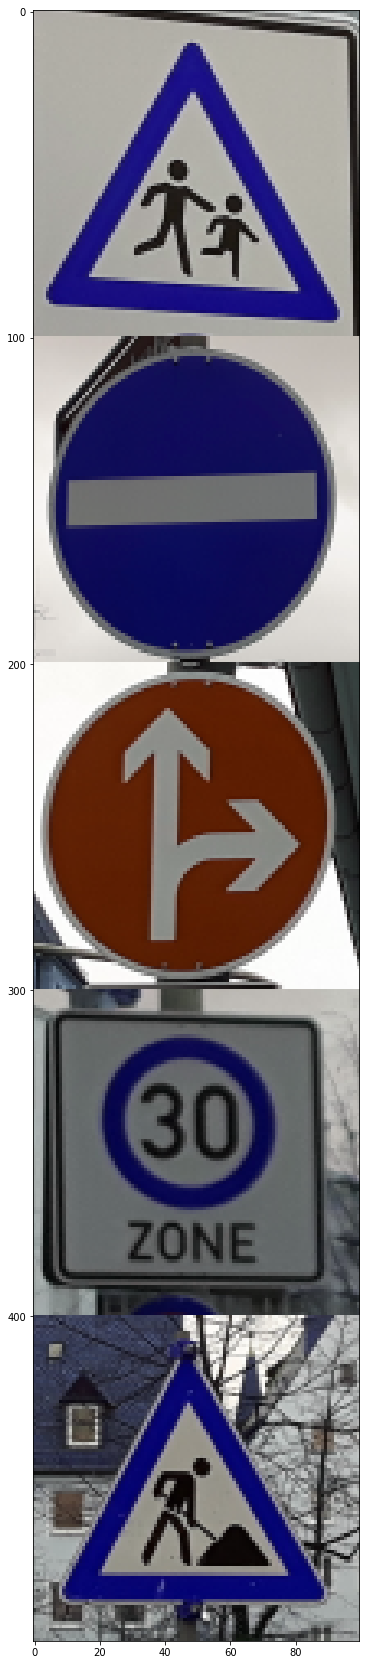

In [28]:
size = 100
num_of_Image = len(filenames)
display_images = 255*np.ones(shape=(size*num_of_Image, size, 3), dtype=np.float32)
for i in range(len(filenames)):
    image = cv2.imread(filenames[i])
    image = cv2.resize(image, (size, size), interpolation=cv2.INTER_AREA)
#     image = cv2.resize(cv2.imread(filenames[i]), (size, size), interpolation=cv2.INTER_AREA)
    yPos = i *size
    display_images[yPos: i*size+size, 0:size, :] = image

plt.imshow(display_images.astype(np.uint8))

In [29]:
test_images = []
for file in filenames:
    image = cv2.imread(file)
    image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    image = normalize(image)
    test_images.append(image)

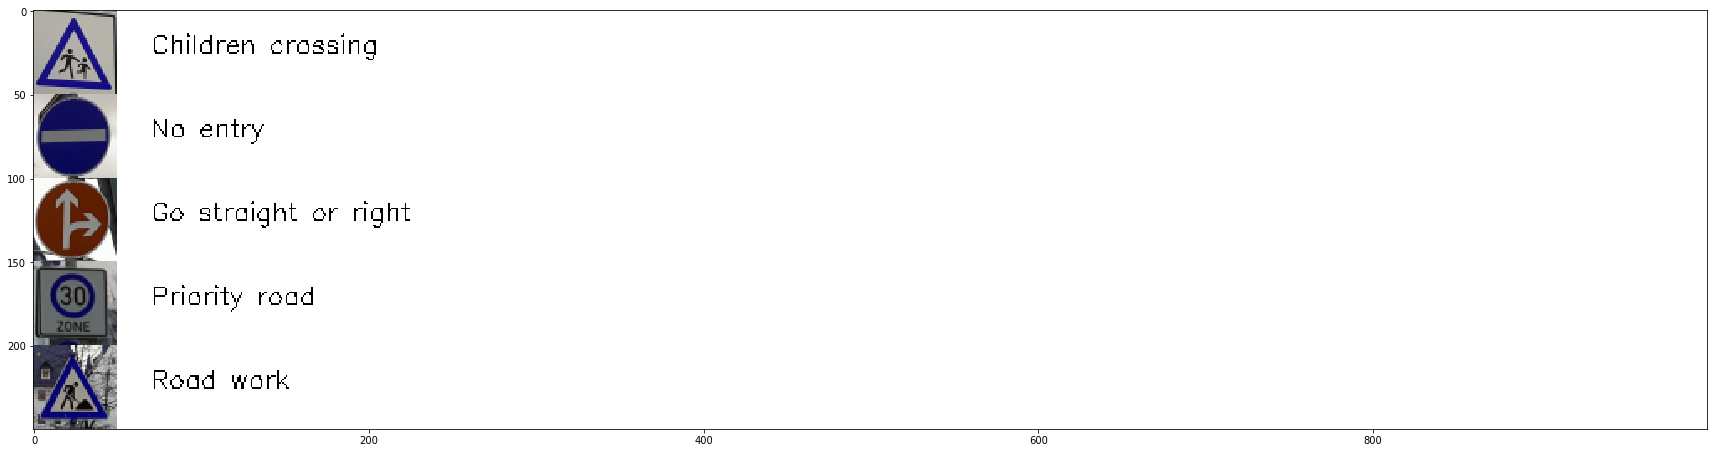

In [30]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './TrafficSigns')
    preds = sess.run(predict, feed_dict={x:test_images, keep_prob:1.0})
    num_of_image = len(filenames)
    result_shape = (50*num_of_image,1000, 3)
    result_image = 255*np.ones(shape=result_shape, dtype=np.float32)
    
    for i in range(preds.shape[0]):
        idx = np.argmax(preds[i])
        name = classNames[idx]
        image = cv2.resize(cv2.imread(filenames[i]), (50, 50), interpolation=cv2.INTER_AREA)
        yPos = i *50
        result_image[yPos: i*50+50, 0:50, :] = image
        cv2.putText(img=result_image, 
                    text='%s'%(name), 
                    org=(50+20, yPos + 25), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=0.5, 
                    color=(0,0,0), 
                    thickness=1
               )
        plt.imshow(result_image.astype(np.uint8))

## Analyze Performance

In [31]:
with tf.Session() as sess:
    values, indices = sess.run(tf.nn.top_k(preds, k=5))
#     print(values)
    for i in range(len(indices)):
        print("{}th image".format(i+1))
        top5 = indices[i]
        top5_value = values[i]
        for i in range(len(top5)):
            print("|{}| {}| {}|".format(i+1, top5_value[i], classNames[top5[i]]))

1th image
|1| 0.9999994039535522| Children crossing|
|2| 4.989233843843977e-07| Road narrows on the right|
|3| 6.80378846595886e-08| Bicycles crossing|
|4| 3.7360202043146273e-08| Beware of ice/snow|
|5| 8.671091400458408e-09| Dangerous curve to the right|
2th image
|1| 1.0| No entry|
|2| 8.156089735880667e-14| Roundabout mandatory|
|3| 4.272130609342395e-14| No passing|
|4| 9.7274144576949e-15| Turn left ahead|
|5| 5.580531730350977e-15| Stop|
3th image
|1| 0.9999829530715942| Go straight or right|
|2| 1.2024164789181668e-05| Keep right|
|3| 1.6545649259569473e-06| End of all speed and passing limits|
|4| 1.4661022760265041e-06| End of no passing|
|5| 8.359966727766732e-07| No vehicles|
4th image
|1| 0.43064796924591064| Priority road|
|2| 0.3934986889362335| Speed limit (60km/h)|
|3| 0.10734185576438904| Keep right|
|4| 0.014809907414019108| Slippery road|
|5| 0.01185572985559702| Speed limit (120km/h)|
5th image
|1| 1.0| Road work|
|2| 6.188184484623503e-18| Dangerous curve to the r

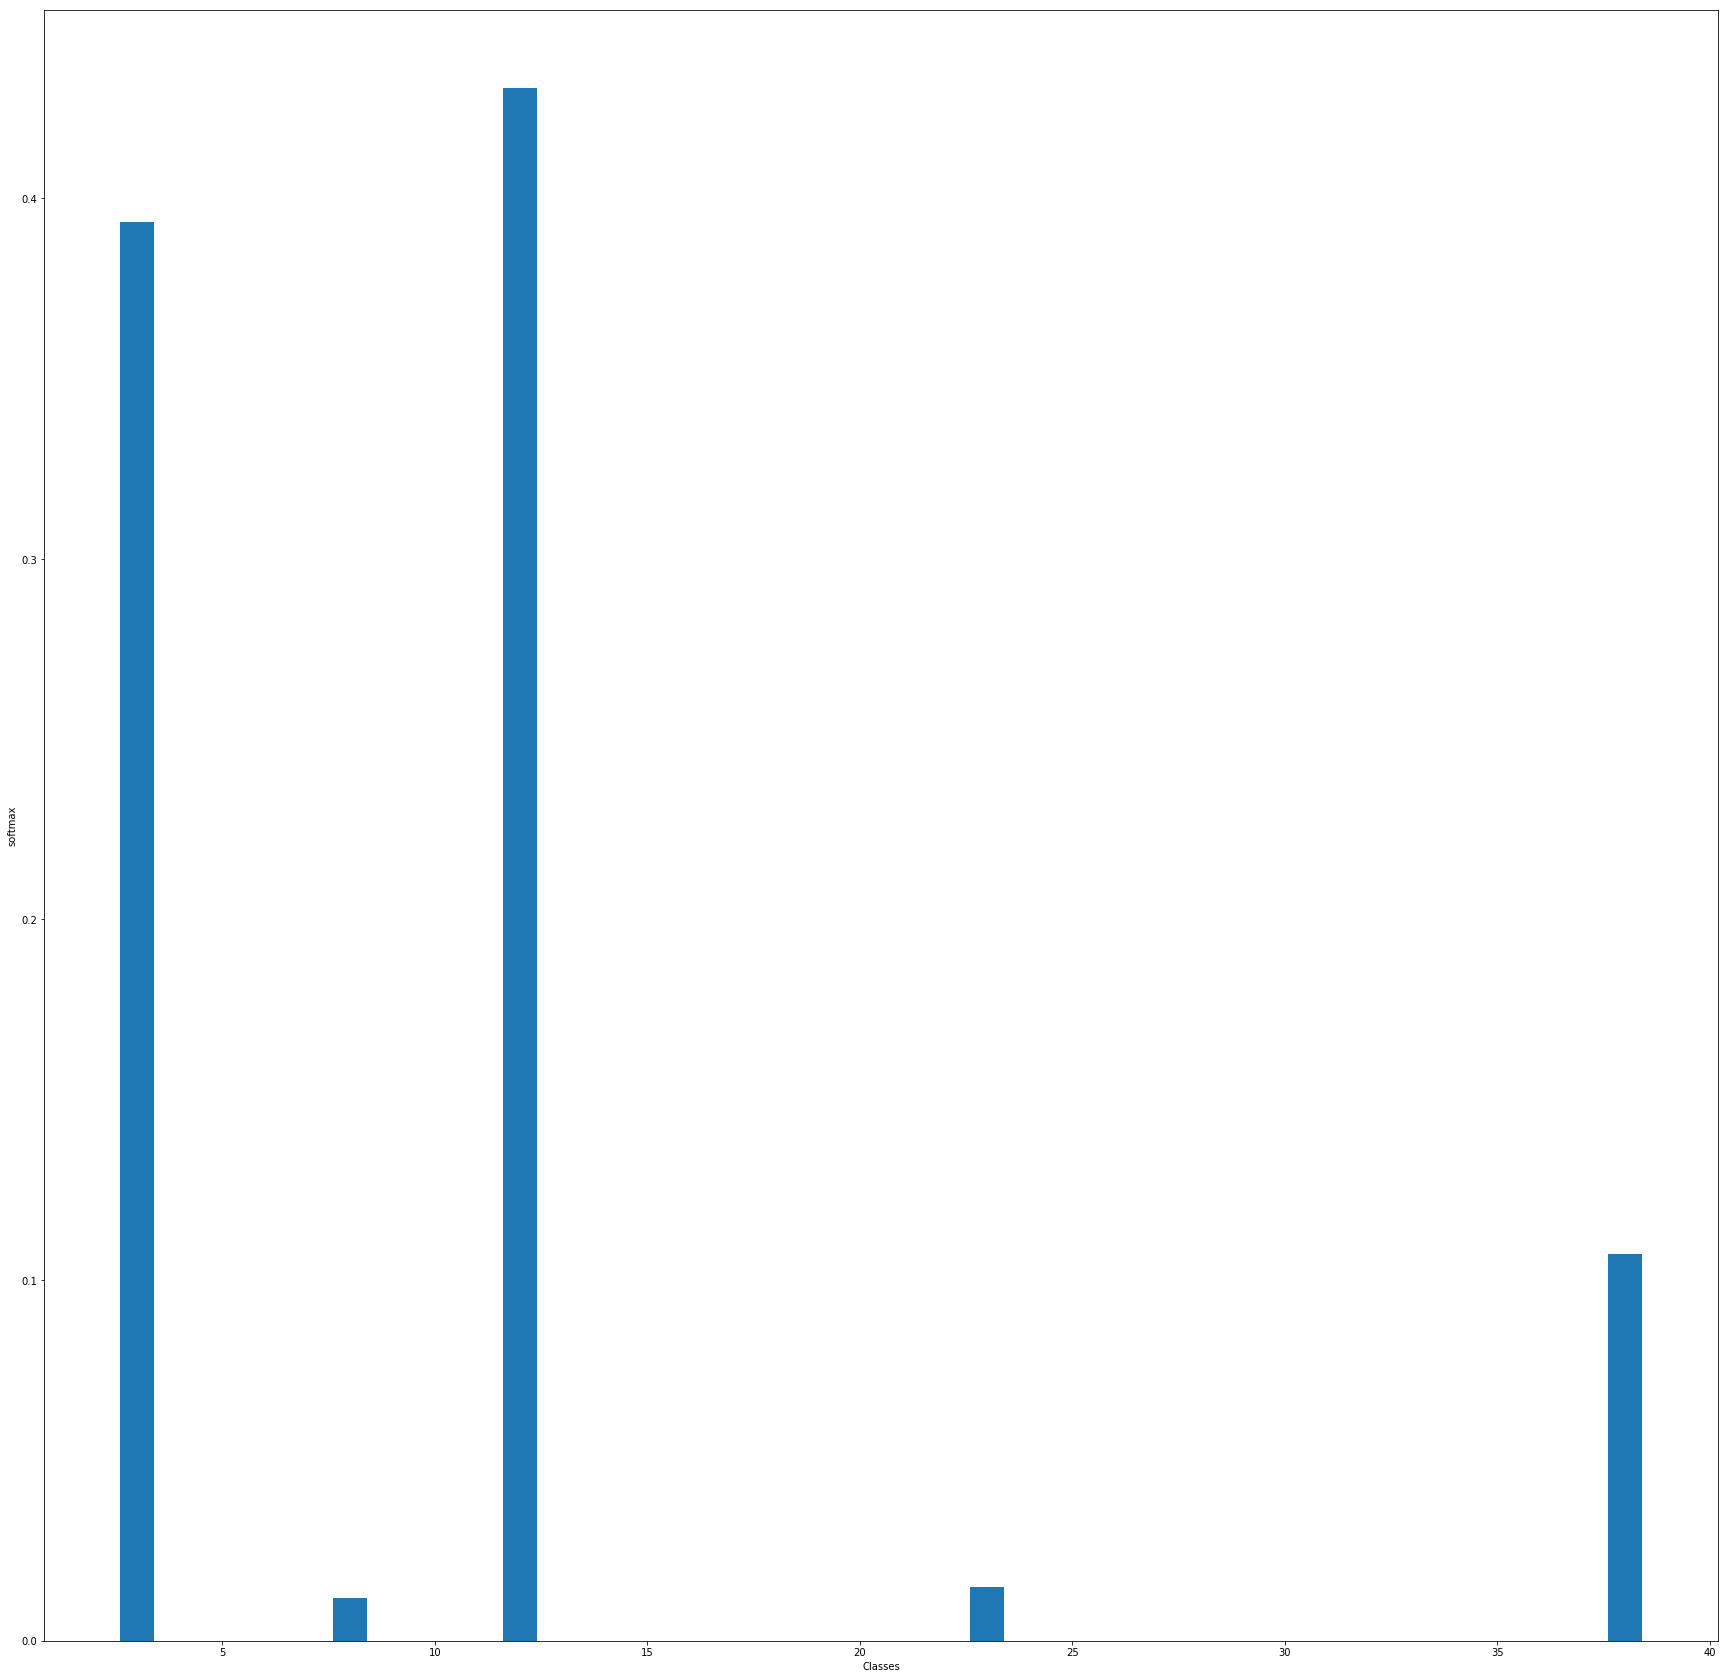

In [44]:
plt.bar(indices[3], values[3])
plt.xlabel('Classes')
plt.ylabel("softmax")
plt.show()

## Visualize Neural network's state

In [33]:
import math
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        num_of_row = math.ceil(featuremaps / 8)
        plt.subplot(num_of_row, 8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

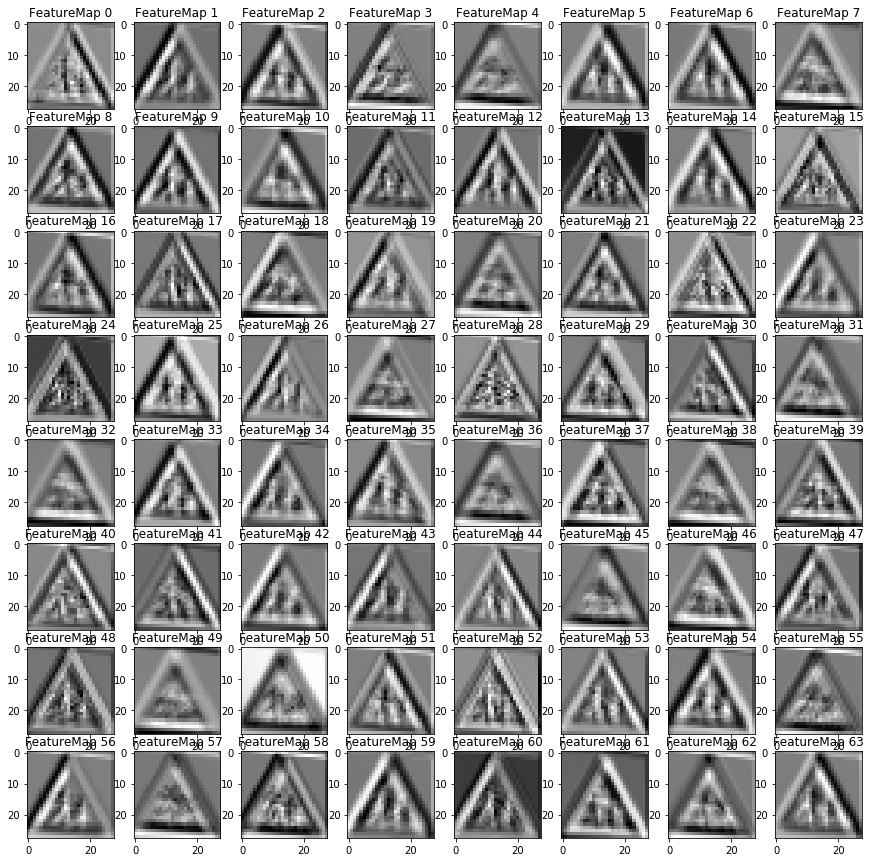

In [40]:
with tf.Session() as sess:
    saver.restore(sess, './TrafficSigns')
    conv1 = sess.graph.get_tensor_by_name('Conv1:0')    
    outputFeatureMap([test_images[0]], tf_activation=conv1, plt_num=64)

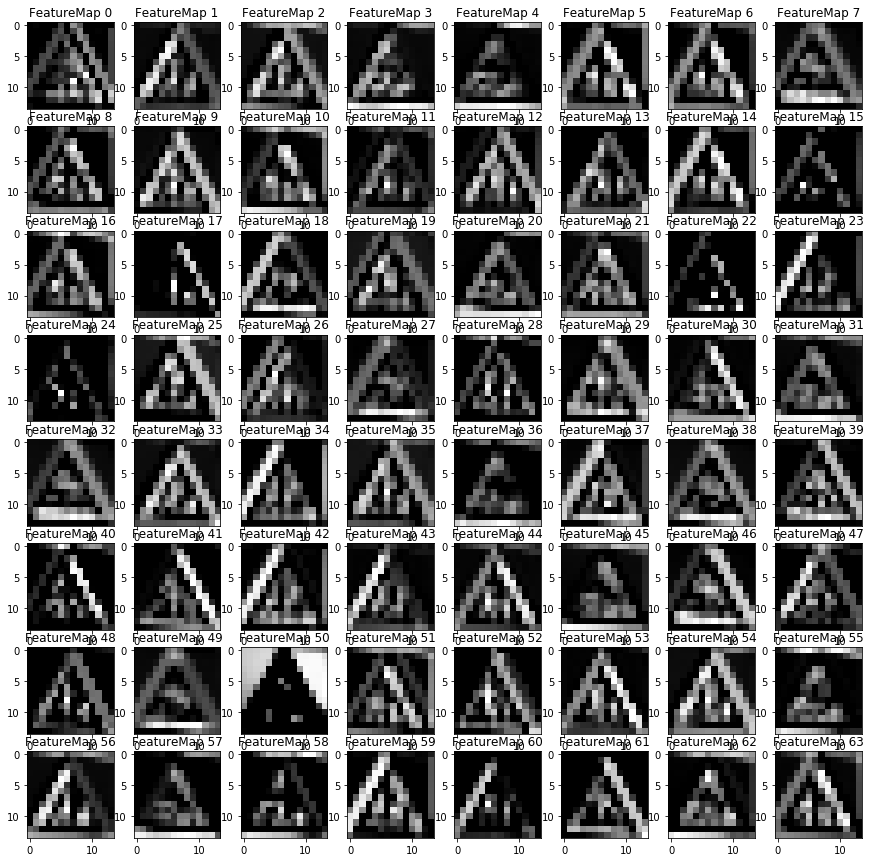

In [41]:
with tf.Session() as sess:
    saver.restore(sess, './TrafficSigns')
    maxpool1 = sess.graph.get_tensor_by_name('MaxPool1:0')
    outputFeatureMap([test_images[0]], tf_activation=maxpool1)

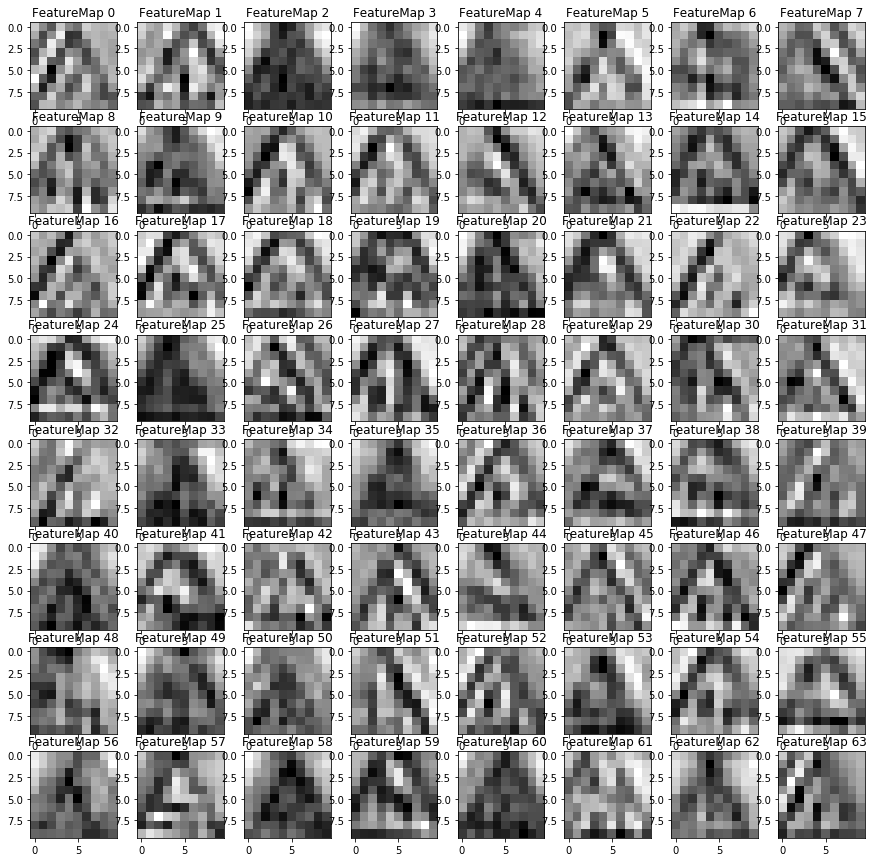

In [42]:
with tf.Session() as sess:
    saver.restore(sess, './TrafficSigns')
    conv2 = sess.graph.get_tensor_by_name('Conv2:0')    
    outputFeatureMap([test_images[0]], tf_activation=conv2)

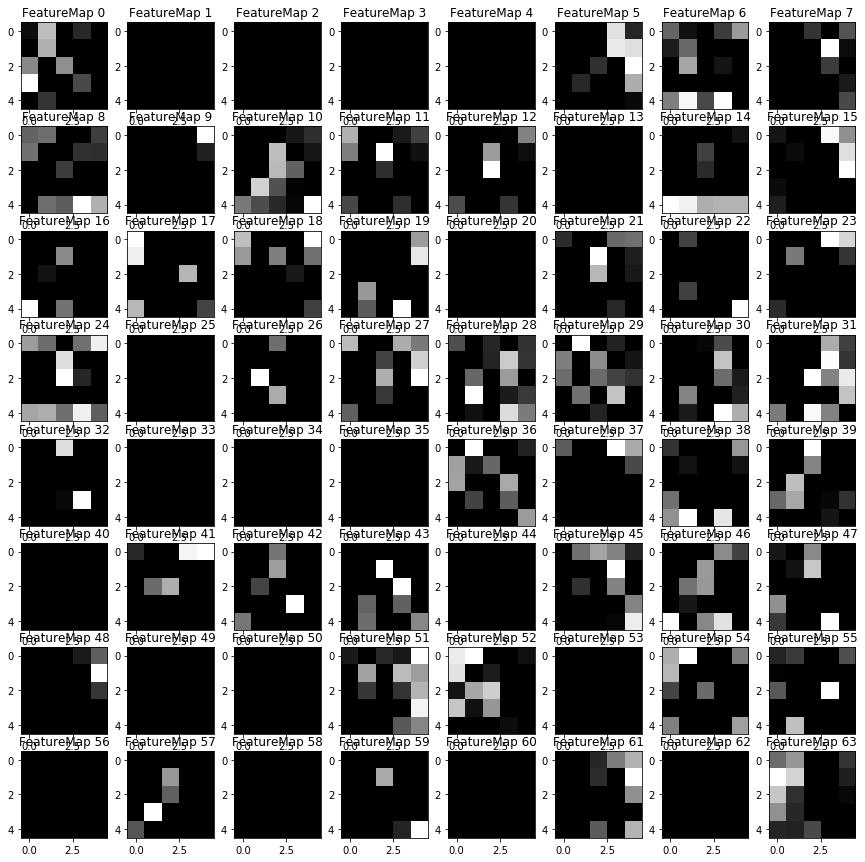

In [43]:
with tf.Session() as sess:
    saver.restore(sess, './TrafficSigns')
    maxpool2 = sess.graph.get_tensor_by_name('MaxPool2:0')
    outputFeatureMap([test_images[0]], tf_activation=maxpool2)